# What are the most demanded skills for the top 3 most popular data roles?

### Methodology

1. Clean-up skill column
2. Calculate skill count based on 'job_title_short'
3. Calculate skill percentage
4. Plot final findings

In [2]:
# Importing Libraries
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import ast 

# Load Datasets
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup (Datetime & 'job_skills' to list type)
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list) 

In [3]:
# Filter for US jobs only
df_US = df[df['job_country'] == 'United States']

In [ ]:
# Split up job skills into separate rows
df_skills = df_US.explode('job_skills')

df_skills[['job_title', 'job_skills']] # Just to check that the job_skills have been broken out

In [ ]:
df_skills_count = df_skills.groupby(['job_skills','job_title_short']).size().reset_index(name = 'skill_count')
# .groupby() usually returns a series data type; .reset_index() to convert back to a DataFrame 
# note: size() counts all rows in the group inclulding NaN values; count() only counts NON-NaN values; Use .agg() for multiple aggregations

df_skills_count = df_skills_count.sort_values(by='skill_count', ascending=False)

df_skills_count

In [45]:
job_titles = sorted(df_US['job_title_short'].value_counts().head(3).index.tolist()) # Finds top 3 job titles with highest count of postings and converts to list 

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

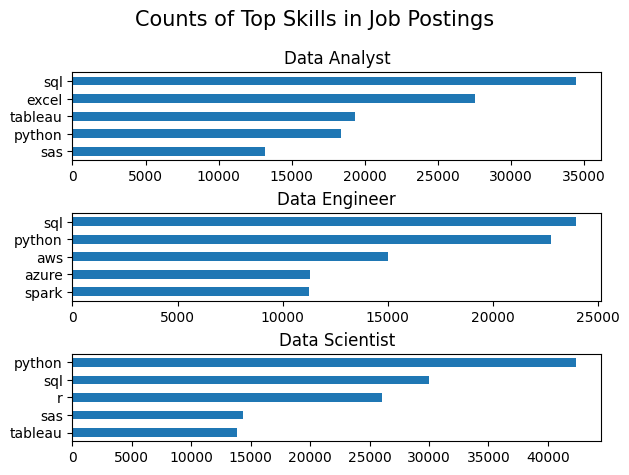

In [61]:
# PLOTTING - Old method

fig, ax = plt.subplots(len(job_titles), 1) # Rows (is the length of the job_titles list), columns = 1

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)
    df_plot.plot(kind = 'barh', x = 'job_skills', y = 'skill_count', ax = ax[i], title = job_title) # x/y values assigned as if it were a normal bar chart not a barh
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].legend().set_visible(False)

fig.suptitle('Counts of Top Skills in Job Postings', fontsize = 15)
fig.tight_layout(h_pad=0.5)
plt.show()

We want % likelihood rather than counts of skills per job title
 - Therefore, we need to add a new column to df_skills_count with the total count of each job and then the % likelihood for that skill in that job

In [68]:
# Finding the total job postings per unique job title in the US dataframe
df_job_title_count = df_US['job_title_short'].value_counts().reset_index(name='jobs_total')

In [75]:
# Merging the job counts df with the skills count df

df_skills_perc = pd.merge(df_skills_count, df_job_title_count, how='left', on='job_title_short') # Left join (Everything from left table will be maintained)

df_skills_perc['skill_perc'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total'])*100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_perc
0,python,Data Scientist,42379,58830,72.036376
1,sql,Data Analyst,34452,67816,50.802171
2,sql,Data Scientist,30034,58830,51.052184
3,excel,Data Analyst,27519,67816,40.578919
4,r,Data Scientist,26022,58830,44.232534
...,...,...,...,...,...
1865,gdpr,Software Engineer,1,1814,0.055127
1866,ggplot2,Business Analyst,1,7382,0.013546
1867,wrike,Business Analyst,1,7382,0.013546
1868,workfront,Data Engineer,1,35080,0.002851


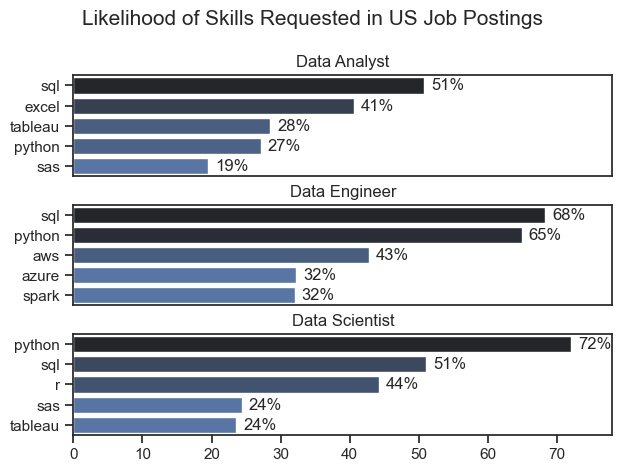

In [96]:
# PLOTTING - Final Version

fig, ax = plt.subplots(len(job_titles), 1) # Rows (is the length of the job_titles list), columns = 1

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    # df_plot.plot(kind = 'barh', x = 'job_skills', y = 'skill_perc', ax = ax[i], title = job_title) # Not required - We've converted to Seaborn plot now
    sns.barplot(data=df_plot, x = 'skill_perc', y = 'job_skills', ax=ax[i], hue = 'skill_perc', palette = 'dark:b_r')
    # ax[i].invert_yaxis() # Seaborn doesn't automatically invert the yaxis tick labels so we dont require this line
    ax[i].set_title(job_title)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_xlim(0,78) # So all subplots are on the same axis
    ax[i].legend().set_visible(False)

    if i != len(job_titles) - 1:
        ax[i].set_xticks([]) # Removes the x axis ticks & labels apart from the last subplot

    for n, v in enumerate(df_plot['skill_perc']): # For the % labels for each individual bar
        ax[i].text(v + 1, n, f'{v:.0f}%', va = 'center')

fig.suptitle('Likelihood of Skills Requested in US Job Postings', fontsize = 15)
fig.tight_layout(h_pad=0.5)
plt.show()